In [171]:
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt

$\frac{\partial u}{\partial t} - \frac{\partial^2u}{\partial x^2} = 0$,      $0\leq x \leq \pi,t\geq 0$  
$u(x,0) = \sin(x)$ :$IC$  
$u(0,t) = u(\pi, t) = 0$, $t\geq 0$ :$BC$

# Setting up

In [172]:
t_0, t_n = 0, 5
x_0, x_n = 0, np.pi
gt_fn = lambda x, t: np.sin(x) * np.exp(-t)
by_x = True

In [173]:
def make_hx(h_t):
    return np.sqrt(2*h_t) * 1.1

def make_ht(h_x, maximum=False):
    fraction = 1.0 if maximum else 0.9
    return 0.5 * np.power(h_x, 2) * fraction

In [174]:
def generate_hs(span = 0.5, min_h = 0.05):
    search_resolution = 0.05  
    max_h = min_h + span
    hs = np.linspace(min_h, max_h, int((max_h - min_h) / search_resolution) + 1)
    make = make_ht if by_x else make_hx
    other_hs = [make(h) for h in hs]
    
    return (hs, other_hs) if by_x else (other_hs, hs)


In [175]:
def make_L(n_x):
    L = np.eye(n_x) * 2 - np.eye(n_x, k=1) - np.eye(n_x, k=-1)
    return L

def make_A_fwd_euler(h_x, h_t, n_x):
    """Returns the matrix A to be multiplied to u at each time step for next time step.
        u(k+1) = A u(k)"""
    L = make_L(n_x)
    return (np.eye(n_x) - (h_t/(h_x**2))*L)

def calc_u_grid(h_x, h_t, x_grid, t_grid, make_A):
    """ Compute the u grid.
        returns a 2D array where each column is the u values at a time step. (n_x, n_t)"""
    n_x = len(x_grid)
    A = make_A(h_x, h_t, n_x)
    
    u_grid = [np.sin(x_grid)] # starting from inital condition
    for _ in t_grid:
        last_u = u_grid[-1]
        u_grid.append(A @ last_u)
    return np.column_stack(u_grid[1:]) # removing initial condition as it is not part of our solution

def get_solution(h_x, h_t, make_A):
    nx = round((x_n - x_0)/h_x) + 1
    h_x = (x_n - x_0)/(nx - 1)

    nt = round((t_n - t_0)/h_t) + 1
    h_t = (t_n - t_0)/(nt - 1)
    
    x_grid = np.linspace(x_0, x_n, nx)[1:-1]
    t_grid = np.linspace(t_0, t_n, nt)[1:]
    print(f"h_t: {h_t:.4f}, h_x: {h_x:.4f} grid: {x_grid.shape[0]} x {t_grid.shape[0]}")
    u_grid = calc_u_grid(h_x, h_t, x_grid, t_grid, make_A)
    # print(f"grid: {x_grid.shape} x {t_grid.shape}")
    return x_grid, t_grid, u_grid, h_x, h_t




In [176]:
def calc_solutions_accross_hs(hxs, hts, make_A):
    return [get_solution(h_x, h_t, make_A) for h_x, h_t in tqdm(zip(hxs, hts))]

# grid calculation

In [177]:
hxs, hts = generate_hs()
print(f"hxs: {hxs}")
print(f"hts: {hts}")
u_grids = calc_solutions_accross_hs(hxs, hts, make_A_fwd_euler)

hxs: [0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55]
hts: [0.0011250000000000003, 0.004500000000000001, 0.010125000000000004, 0.018000000000000006, 0.028125, 0.0405, 0.055125000000000014, 0.07200000000000002, 0.09112500000000001, 0.1125, 0.13612500000000002]


11it [00:00, 135.92it/s]

h_t: 0.0011, h_x: 0.0499 grid: 62 x 4444
h_t: 0.0045, h_x: 0.1013 grid: 30 x 1111
h_t: 0.0101, h_x: 0.1496 grid: 20 x 494
h_t: 0.0180, h_x: 0.1963 grid: 15 x 278
h_t: 0.0281, h_x: 0.2417 grid: 12 x 178
h_t: 0.0407, h_x: 0.3142 grid: 9 x 123
h_t: 0.0549, h_x: 0.3491 grid: 8 x 91
h_t: 0.0725, h_x: 0.3927 grid: 7 x 69
h_t: 0.0909, h_x: 0.4488 grid: 6 x 55
h_t: 0.1136, h_x: 0.5236 grid: 5 x 44
h_t: 0.1351, h_x: 0.5236 grid: 5 x 37


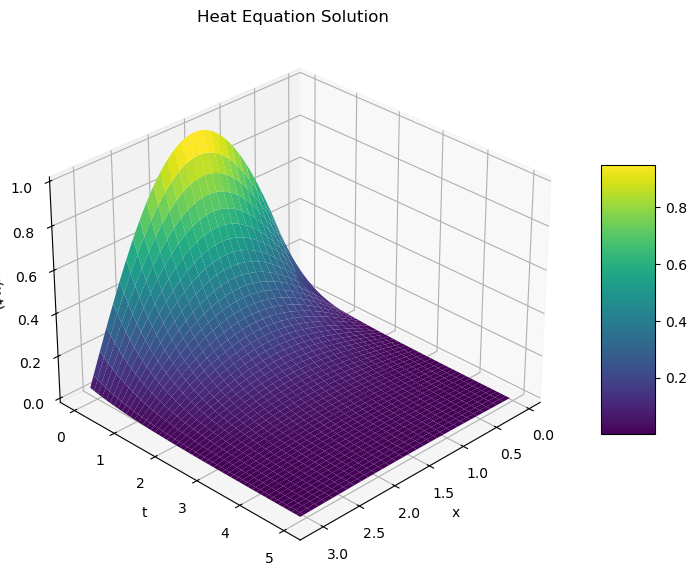

In [ ]:
%matplotlib inline

from mpl_toolkits.mplot3d import Axes3D

def plot_solution_3d(x_axis, t_axis, u_grid, name_suffix=""):
    """
    Plot 3D surface of solution (interactive).
    
    Args:
        x_axis: 1D array of x values
        t_axis: 1D array of t values
        u_grid: 2D array of shape (len(x_axis), len(t_axis))
    """
    X, T = np.meshgrid(x_axis, t_axis, indexing='ij')
    
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    
    surf = ax.plot_surface(X, T, u_grid, cmap='viridis')
    
    ax.set_xlabel('x')
    ax.set_ylabel('t')
    ax.set_zlabel('u(x,t)')
    ax.set_title('Heat Equation Solution')
    ax.view_init(elev=30, azim=45)
    fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)
    plt.savefig(f"3d_solution_plot_{name_suffix}.png")

# Usage with your data:
x_grid, t_grid, u_grid, h_x, h_t = u_grids[0]  # pick a solution
plot_solution_3d(x_grid, t_grid, u_grid, "4_1")

# Error calculation setup

In [179]:
def eval_fn(x_grid, t_grid, fn):
    # print(f"x_grid: {x_grid}")
    return np.array([
        [fn(x, t) for t in t_grid]
    for x in x_grid])
    # print(f"u shape: {u_grid.shape}")


def relative_error(x_grid, t_grid, u_grid, fn):
    gt_samples = eval_fn(x_grid, t_grid, fn)
    errors = u_grid - gt_samples
    err_norm = np.linalg.norm(errors, axis=0)
    solution_norm = np.linalg.norm(gt_samples, axis=0)
    # print(f"u norm: {solution_norm}, err : {err_norm}")
    # print(f"div: {err_norm / solution_norm}")
    # print(f"gt norm: {np.linalg.norm(gt_samples)}")
    return err_norm / solution_norm

In [180]:
def calc_rel_err_under(u_grids):
    err_grids = []
    for s in u_grids:
        x_grid, t_grid, u_grid, h_x, h_t = s
        rel_err_vec = relative_error(x_grid, t_grid, u_grid, gt_fn)
        infinte_norm = np.linalg.norm(rel_err_vec, ord=np.inf)

        err_grids.append((x_grid, t_grid, u_grid, h_x, h_t, infinte_norm))
        # print(f"h_x: {h_x}, h_t: {h_t} max: {infinte_norm}")

    return err_grids

def find_rel_err_under(err_grids, percent=0.02):
    filtered_list = list(filter(lambda s: s[-1] <= percent, err_grids))
    return min(filtered_list, key=lambda s: s[-3])


In [181]:
def plot_errs_vs_hs(hs, errs, by_x=True, name_suffix=""):
    plt.figure(figsize=(6,4))
    plt.plot(hs, errs, '-o')

    # plt.xticks(h_ts)

    # plt.yticks(errs)
    axis ='h_x' if by_x else 'h_t'
    plt.xlabel(axis)
    plt.ylabel('max relative error (inf norm)')
    plt.title(f'Error vs time step {axis}')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.savefig(f"error_vs_h_{name_suffix}.png")


# Relative error Calculation

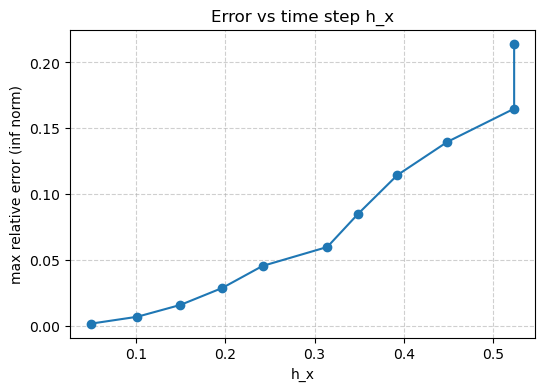

In [ ]:
u_grids_err = calc_rel_err_under(u_grids)

def plot_err_across_search_domain(u_grids_err, name_suffix=""):
    hs = [h_x if by_x else h_t for x_grid, t_grid, u_grid, h_x, h_t, err in u_grids_err]
    errs = [err for x_grid, t_grid, u_grid, h_x, h_t, err in u_grids_err]
    plot_errs_vs_hs(hs, errs, name_suffix=name_suffix)

plot_err_across_search_domain(u_grids_err, "4_1")


============== Found error under 0.02 ==============
h_x: 0.049866550056980846, h_t: 0.0011251125112511251, error: 0.0017761190536112474


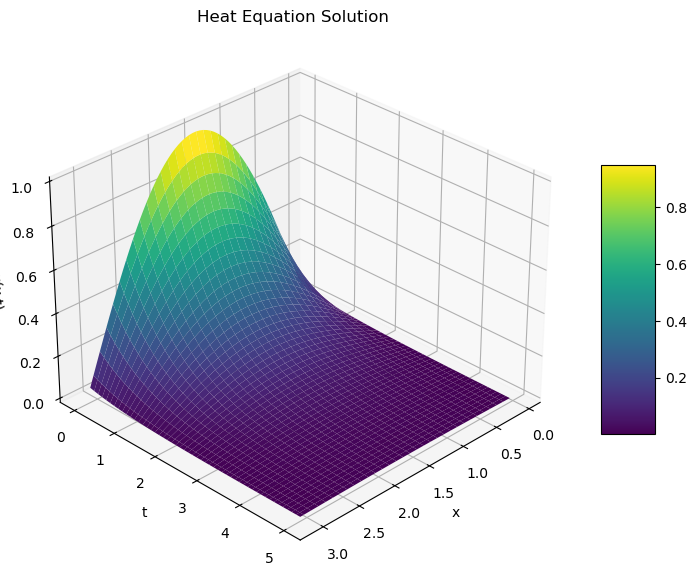

In [ ]:
acc_x, acc_t, acc_u, acc_h_x, acc_h_t, err = find_rel_err_under(u_grids_err)
print("============== Found error under 0.02 ==============")
print(f"h_x: {acc_h_x}, h_t: {acc_h_t}, error: {err}")
plot_solution_3d(acc_x, acc_t, acc_u, "4_1_best")
Q41_acc = (acc_h_x, acc_h_t, err)

calculating solutions:


0it [00:00, ?it/s]

h_t: 0.0003, h_x: 0.0262 grid: 119 x 17776


3it [00:00,  7.40it/s]


h_t: 0.0006, h_x: 0.0370 grid: 84 x 8888
h_t: 0.0011, h_x: 0.0524 grid: 59 x 4444
calculating relative error:


100%|██████████| 3/3 [00:18<00:00,  6.16s/it]


hts_0: [0.0002812781278127813, 0.0005625562556255626, 0.0011251125112511251]
errs_0: [0.0004175873435327575, 0.0008370919886252127, 0.0016699994985985673]
1.9950011722621663
2.004591378520904


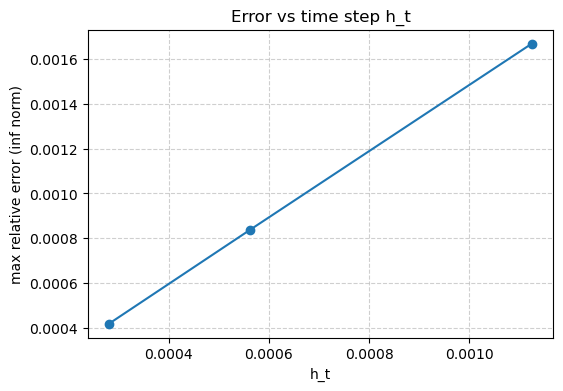

In [ ]:
ht0s = [acc_h_t / 4, acc_h_t / 2, acc_h_t]
hx0s = [make_hx(ht0) for ht0 in ht0s]

print(f"calculating solutions:")
u_grids_0 = [get_solution(h_x, h_t, make_A_fwd_euler) for h_x, h_t in tqdm(zip(hx0s, ht0s))]

print(f"calculating relative error:")
errs_0 = [np.linalg.norm(relative_error(x_grid, t_grid, u_grid, gt_fn), ord=np.inf) for x_grid, t_grid, u_grid, h_x, h_t in tqdm(u_grids_0)]
print(f"hts_0: {ht0s}")
print(f"errs_0: {errs_0}")

plot_errs_vs_hs(ht0s, errs_0, by_x=False, name_suffix="4_1")
print(errs_0[-1] / errs_0[-2])
print(errs_0[-2] / errs_0[-3])

# 4.2

In [185]:
from os import name


def test_higher_ht(acc_h_x, higher_h_t, make_A):
    x_grid, t_grid, u_grid, h_x, h_t = get_solution(acc_h_x, higher_h_t, make_A)
    gt = eval_fn(x_grid, t_grid, gt_fn)
    err_grid = u_grid - gt
    errs = np.linalg.norm(err_grid, axis=0)
    return t_grid, errs, h_x, h_t

def plot_errs_vs_t(errs, t, log_scale=False, name_suffix=""):
    if isinstance(errs, list):
        for i in range(len(errs)):
            plt.plot(t[i], errs[i], '-', label=f'factor {i+1}')
        plt.legend()
    else:
        plt.plot(t, errs, '-')

    # plt.xticks(h_ts)

    # plt.yticks(errs)
    if(log_scale):  
        plt.yscale('log')
    plt.xlabel('t')
    plt.ylabel('||e^(k)||')
    plt.title(f'Error vs time ')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.savefig(f"error_vs_t_{name_suffix}.png")

h_t: 0.0017, h_x: 0.0499 grid: 62 x 2963


C:\Users\tomyl\AppData\Local\Temp\ipykernel_29356\1368868178.py:20: RuntimeWarning: overflow encountered in matmul
  u_grid.append(A @ last_u)
C:\Users\tomyl\AppData\Local\Temp\ipykernel_29356\1368868178.py:20: RuntimeWarning: invalid value encountered in matmul
  u_grid.append(A @ last_u)
c:\ProgramData\anaconda3\Lib\site-packages\numpy\linalg\linalg.py:2582: RuntimeWarning: overflow encountered in multiply
  s = (x.conj() * x).real
c:\ProgramData\anaconda3\Lib\site-packages\numpy\linalg\linalg.py:2583: RuntimeWarning: overflow encountered in reduce
  return sqrt(add.reduce(s, axis=axis, keepdims=keepdims))


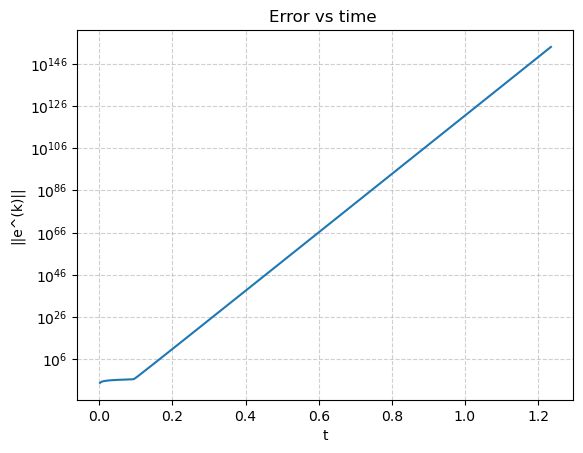

In [ ]:
higher_ht0 = acc_h_t * 1.5
t_grid, errs, _, _ = test_higher_ht(acc_h_x, higher_ht0, make_A_fwd_euler)
plot_errs_vs_t(errs, t_grid, log_scale=True, name_suffix="4_2")



# 4.3

In [187]:
def make_A_bwd_euler(h_x, h_t, n_x):
    """Returns the matrix A to be multiplied to u at each time step for next time step.
        u(k+1) = A u(k)"""
    L = make_L(n_x)
    return np.linalg.inv(np.eye(n_x) + (h_t/(h_x**2))*L)

In [188]:
hxs, hts = generate_hs()
print(f"hxs: {hxs}")
print(f"hts: {hts}")
u_grids = calc_solutions_accross_hs(hxs, hts, make_A_bwd_euler)

hxs: [0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55]
hts: [0.0011250000000000003, 0.004500000000000001, 0.010125000000000004, 0.018000000000000006, 0.028125, 0.0405, 0.055125000000000014, 0.07200000000000002, 0.09112500000000001, 0.1125, 0.13612500000000002]


11it [00:00, 109.39it/s]

h_t: 0.0011, h_x: 0.0499 grid: 62 x 4444
h_t: 0.0045, h_x: 0.1013 grid: 30 x 1111
h_t: 0.0101, h_x: 0.1496 grid: 20 x 494
h_t: 0.0180, h_x: 0.1963 grid: 15 x 278
h_t: 0.0281, h_x: 0.2417 grid: 12 x 178
h_t: 0.0407, h_x: 0.3142 grid: 9 x 123
h_t: 0.0549, h_x: 0.3491 grid: 8 x 91
h_t: 0.0725, h_x: 0.3927 grid: 7 x 69
h_t: 0.0909, h_x: 0.4488 grid: 6 x 55
h_t: 0.1136, h_x: 0.5236 grid: 5 x 44
h_t: 0.1351, h_x: 0.5236 grid: 5 x 37


============== Found error under 0.02 ==============
h_x: 0.049866550056980846, h_t: 0.0011251125112511251, error: 0.0038529403998920756


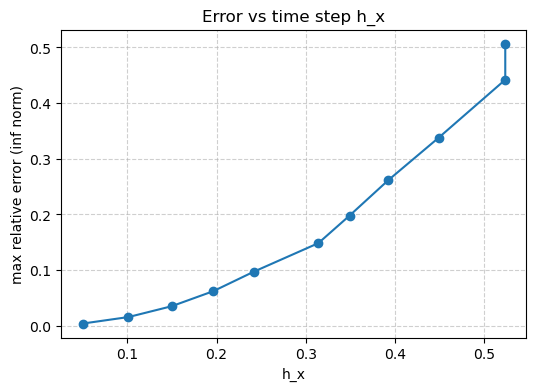

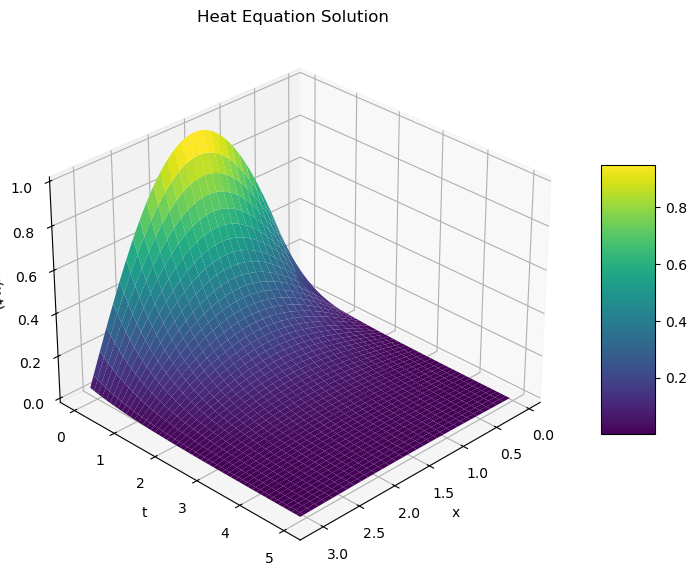

In [ ]:
u_grids_err = calc_rel_err_under(u_grids)
plot_err_across_search_domain(u_grids_err, "4_3")
acc_x, acc_t, acc_u, acc_h_x, acc_h_t, err = find_rel_err_under(u_grids_err)
print("============== Found error under 0.02 ==============")
print(f"h_x: {acc_h_x}, h_t: {acc_h_t}, error: {err}")
plot_solution_3d(acc_x, acc_t, acc_u, "4_3")

calculating solutions:


0it [00:00, ?it/s]

h_t: 0.0003, h_x: 0.0262 grid: 119 x 17776


3it [00:00,  8.11it/s]


h_t: 0.0006, h_x: 0.0370 grid: 84 x 8888
h_t: 0.0011, h_x: 0.0524 grid: 59 x 4444
calculating relative error:


100%|██████████| 3/3 [00:18<00:00,  6.16s/it]


hts_0: [0.0002812781278127813, 0.0005625562556255626, 0.0011251125112511251]
errs_0: [0.0004175873435327575, 0.0008370919886252127, 0.0016699994985985673]
1.9950011722621663
2.004591378520904


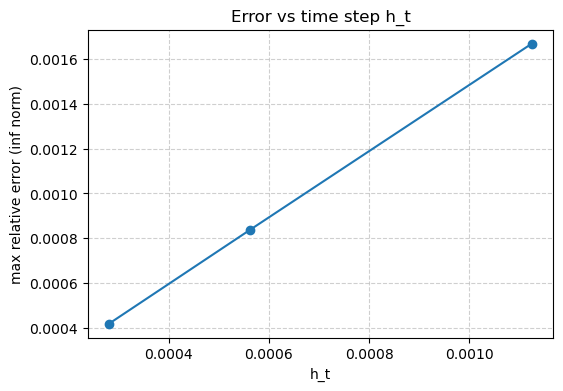

In [ ]:
ht0s = [acc_h_t / 4, acc_h_t / 2, acc_h_t]
hx0s = [make_hx(ht0) for ht0 in ht0s]

print(f"calculating solutions:")
u_grids_0 = [get_solution(h_x, h_t, make_A_fwd_euler) for h_x, h_t in tqdm(zip(hx0s, ht0s))]

print(f"calculating relative error:")
errs_0 = [np.linalg.norm(relative_error(x_grid, t_grid, u_grid, gt_fn), ord=np.inf) for x_grid, t_grid, u_grid, h_x, h_t in tqdm(u_grids_0)]
print(f"hts_0: {ht0s}")
print(f"errs_0: {errs_0}")

plot_errs_vs_hs(ht0s, errs_0, by_x=False, name_suffix="4_3")
print(errs_0[-1] / errs_0[-2])
print(errs_0[-2] / errs_0[-3])

In [191]:
def compare_to_section_1():
    x_grid, t_grid, u_grid, h_x, h_t = get_solution(Q41_acc[0], Q41_acc[1], make_A_bwd_euler)
    err_vec = relative_error(x_grid, t_grid, u_grid, gt_fn)
    inf_norm = np.linalg.norm(err_vec, ord=np.inf)
    print(f"Section 1 accuracy h_x: {h_x}, h_t: {h_t}")
    print(f"section 1 inf norm: {inf_norm} current inf norm: {Q41_acc[2]}")

# 4.4

higher_ht0:  0.0006806930693069308
h_t: 0.0007, h_x: 0.0370 grid: 84 x 7345
higher_ht0:  0.0013613861386138615
h_t: 0.0014, h_x: 0.0370 grid: 84 x 3673
higher_ht0:  0.002042079207920792
h_t: 0.0020, h_x: 0.0370 grid: 84 x 2448
higher_ht0:  0.002722772277227723
h_t: 0.0027, h_x: 0.0370 grid: 84 x 1836
higher_ht0:  0.003403465346534654
h_t: 0.0034, h_x: 0.0370 grid: 84 x 1469
higher_ht0:  0.004084158415841584
h_t: 0.0041, h_x: 0.0370 grid: 84 x 1224
higher_ht0:  0.004764851485148516
h_t: 0.0048, h_x: 0.0370 grid: 84 x 1049
higher_ht0:  0.005445544554455446
h_t: 0.0054, h_x: 0.0370 grid: 84 x 918


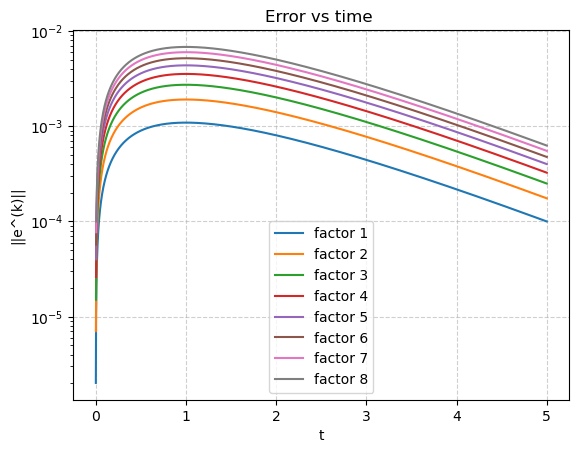

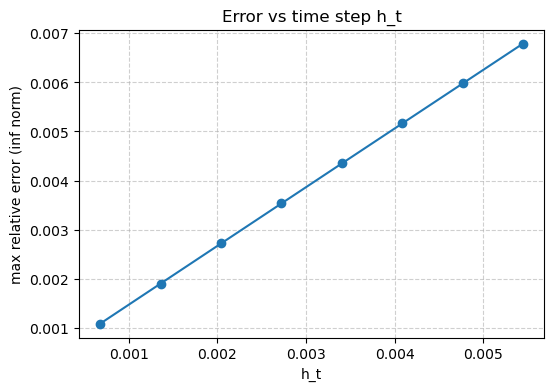

In [ ]:
h_x_middle = hx0s[1]
h_t_middle = make_ht(h_x_middle, maximum=True)
factors = list(range(1, 9))

ts_list = []
errs_list = []
h_ts_list = []
inf_norm = []
for f in factors:
    higher_ht0 = h_t_middle * f
    print("higher_ht0: ", higher_ht0)
    t_grid, errs, h_x, h_t = test_higher_ht(h_x_middle, higher_ht0, make_A_bwd_euler)
    inf_norm.append(np.linalg.norm(errs, ord=np.inf))
    h_ts_list.append(h_t)
    errs_list.append(errs)
    ts_list.append(t_grid)
    
plot_errs_vs_t(errs_list, ts_list, log_scale=True, name_suffix="4_4")
plot_errs_vs_hs(h_ts_list, inf_norm, by_x=False, name_suffix="4_4")